### This... didn't really work. See the cluster_centrality file

In [1]:
import pandas as pd

articles = pd.read_csv('../process_articles/validated_articles.csv')
articles.head(1)

,authors,title,date,year,edition,url,text,quarter,year_quarter
0,NaN,本期导读,2023-01-01,2023,1.0,http://www.qstheory.cn/dukan/qs/2023-01/01/c_1...,本期发表了习近平总书记的重要讲话《为实现党的二十大确定的目标任务而团结奋斗》。讲话强调，全面...,1,2023 Q1


## Check out the length of the articles - I think some models have token limits

In [2]:
articles['text_length'] = articles['text'].apply(lambda x: len(x))

In [3]:
articles['text_length'].describe()

count     1998.000000
mean      4651.866867
std       3015.892857
min        237.000000
25%       1815.750000
50%       5047.500000
75%       6742.250000
max      32678.000000
Name: text_length, dtype: float64

<Axes: xlabel='text_length', ylabel='Count'>

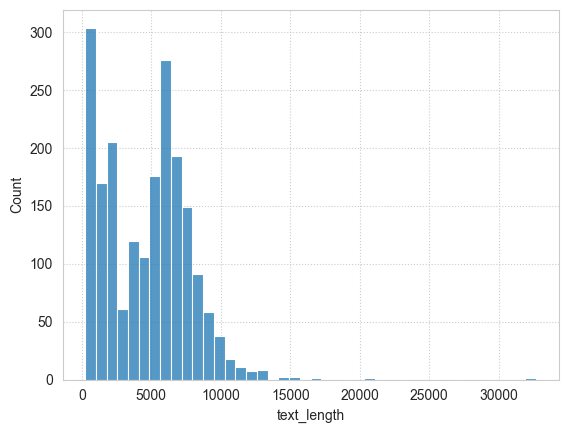

In [4]:
import seaborn as sns

sns.set_style("whitegrid", {'grid.linestyle': ':'})

sns.histplot(data=articles, x='text_length')

<Axes: xlabel='text_length'>

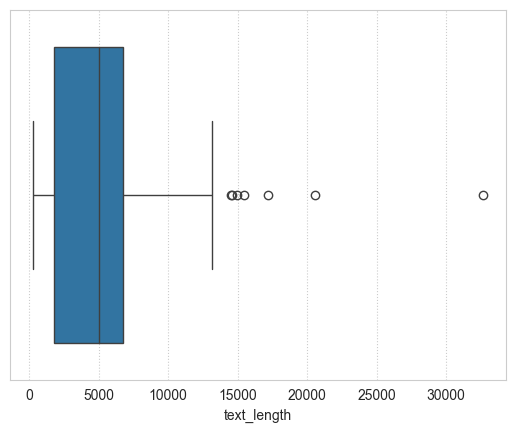

In [5]:
sns.boxplot(data=articles, x='text_length')

In [6]:
long_articles = articles[articles['text_length'] >= 15000]
len(long_articles)

4

In [7]:
long_articles

,authors,title,date,year,edition,url,text,quarter,year_quarter,text_length
819,['习近平'],高举中国特色社会主义伟大旗帜 为全面建设社会主义现代化国家而团结奋斗,2022-11-01,2022,21.0,http://www.qstheory.cn/dukan/qs/2022-11/01/c_1...,高举中国特色社会主义伟大旗帜为全面建设社会主义现代化国家而团结奋斗——在中国共产党第二十次全...,4,2022 Q4,32678
820,NaN,十九届中央纪律检查委员会向中国共产党第二十次全国代表大会的工作报告,2022-11-01,2022,21.0,http://www.qstheory.cn/dukan/qs/2022-11/01/c_1...,十九届中央纪律检查委员会向中国共产党第二十次全国代表大会的工作报告（2022年10月22日中...,4,2022 Q4,17211
821,NaN,中国共产党章程,2022-11-01,2022,21.0,http://www.qstheory.cn/dukan/qs/2022-11/01/c_1...,中国共产党章程（中国共产党第二十次全国代表大会部分修改，2022年10月22日通过）总 纲中...,4,2022 Q4,20540
1032,['《求是》杂志编辑部'],红色江山永不变色,2021-05-15,2021,10.0,http://www.qstheory.cn/dukan/qs/2021-05/15/c_1...,红色江山永不变色《求是》杂志编辑部“新中国是无数革命先烈用鲜血和生命铸就的。要深刻认识红色政...,2,2021 Q2,15459


In [8]:
list(long_articles['url'])

['http://www.qstheory.cn/dukan/qs/2022-11/01/c_1129089160.htm',
 'http://www.qstheory.cn/dukan/qs/2022-11/01/c_1129089158.htm',
 'http://www.qstheory.cn/dukan/qs/2022-11/01/c_1129089139.htm',
 'http://www.qstheory.cn/dukan/qs/2021-05/15/c_1127446921.htm']

## Calculate Cosine Similarity between all articles

In [144]:
# load the data
import pandas as pd

articles = pd.read_csv('../process_articles/processed_articles.csv')
print(len(articles))

1998


In [145]:
# import a list of Chinese stopwords, and remove them from the text
from stopwordsiso import stopwords

stopwords_zh = stopwords(["zh"])

def remove_stopwords(row_text):
    return [word for word in row_text.split(" ") if word not in stopwords_zh]

articles['cleaned_text_wspaces'] = articles['cleaned_text_wspaces'].apply(lambda row_text: remove_stopwords(row_text))

docs = list(articles['cleaned_text_wspaces'])

In [146]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)


In [147]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [148]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [149]:
from gensim.models import TfidfModel
from gensim import similarities

# Step 3: Apply TF-IDF Transformation
tfidf_model = TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf_model[corpus]

# Step 4: Create MatrixSimilarity object
index = similarities.MatrixSimilarity(corpus_tfidf)

# Step 5: Compute Cosine Similarity
sims = index[corpus_tfidf]

In [150]:
sims.shape

(1998, 1998)

In [151]:
def determine_older_article(a_index, a_year, a_edition, b_index, b_year, b_edition):
    if (a_year) > (b_year):
        return b_index, a_index, False
    elif (a_year) < (b_year):
        return a_index, b_index, False
    # years are the same
    elif a_edition > b_edition:
        return b_index, a_index, False
    elif a_edition < b_edition:
        return a_index, b_index, False
    # if they are from the same edition, there isn't an older to influence a 
    # newer, so return an indicator
    else: 
        return None, None, True

source = []
target = []
cosine_similarity = []

simplified_articles = articles.drop(columns=[column for column in articles.columns if column not in ['date', 'title', 'year', 'edition', 'authors']])

def get_graph_edges():
    for i in range(len(sims)):
        # do the lower triange in the symmetric nxn matrix
        for j in range(i+1):
            # this is like doing loc not iloc, it looks at the row with index i, not the ith row
            i_year = simplified_articles.at[i, 'year']
            i_edition = simplified_articles.at[i, 'edition']
            j_year = simplified_articles.at[j, 'year']
            j_edition = simplified_articles.at[j, 'edition']

            older_index, newer_index, same_edition = determine_older_article(i, i_year, i_edition, j, j_year, j_edition)

            if same_edition:
                continue

            source.append(newer_index)
            target.append(older_index)
            cosine_similarity.append(sims[i][j])

get_graph_edges()

In [152]:
# %load_ext line_profiler
# %lprun -f get_graph_edges get_graph_edges()

In [156]:
df_edges_weighted = pd.DataFrame({'source':source, 'target':target, 'cosine_similarity': cosine_similarity})
len(df_edges_weighted)

1978937

## Combine cosine similarity with other info

In [158]:
simplified_articles.head(5)

,authors,title,date,year,edition
0,['习近平'],辩证唯物主义是中国共产党人的世界观和方法论,2018-12-31,2019,1.0
1,"['刘雅鸣', '陈聪', '李亚楠', '宋晓东']",兰考：会它千顷澄碧,2019-01-01,2019,1.0
2,['国家统计局'],经济社会发展统计：改革开放40年辉煌成就（经济篇）,2019-01-01,2019,1.0
3,['《中直党建》评论员'],多敲警钟才能少敲丧钟,2019-01-01,2019,1.0
4,['李君'],学理论是党员领导干部的责任,2019-01-01,2019,1.0


In [159]:
df_edges_weighted['source_author'] = df_edges_weighted['source'].apply(lambda x: simplified_articles.at[x, 'authors'])
df_edges_weighted['target_author'] = df_edges_weighted['target'].apply(lambda x: simplified_articles.at[x, 'authors'])
df_edges_weighted['source_title'] = df_edges_weighted['source'].apply(lambda x: simplified_articles.at[x, 'title'])
df_edges_weighted['target_title'] = df_edges_weighted['target'].apply(lambda x: simplified_articles.at[x, 'title'])
df_edges_weighted['source_date'] = df_edges_weighted['source'].apply(lambda x: simplified_articles.at[x, 'date'])
df_edges_weighted['target_date'] = df_edges_weighted['target'].apply(lambda x: simplified_articles.at[x, 'date'])


In [160]:
df_edges_weighted.head(5)

,source,target,cosine_similarity,source_author,target_author,source_title,target_title,source_date,target_date
0,16,0,0.070548,['习近平'],['习近平'],努力造就一支忠诚干净担当的高素质干部队伍,辩证唯物主义是中国共产党人的世界观和方法论,2019-01-15,2018-12-31
1,16,1,0.028504,['习近平'],"['刘雅鸣', '陈聪', '李亚楠', '宋晓东']",努力造就一支忠诚干净担当的高素质干部队伍,兰考：会它千顷澄碧,2019-01-15,2019-01-01
2,16,2,0.006777,['习近平'],['国家统计局'],努力造就一支忠诚干净担当的高素质干部队伍,经济社会发展统计：改革开放40年辉煌成就（经济篇）,2019-01-15,2019-01-01
3,16,3,0.022255,['习近平'],['《中直党建》评论员'],努力造就一支忠诚干净担当的高素质干部队伍,多敲警钟才能少敲丧钟,2019-01-15,2019-01-01
4,16,4,0.070219,['习近平'],['李君'],努力造就一支忠诚干净担当的高素质干部队伍,学理论是党员领导干部的责任,2019-01-15,2019-01-01


In [161]:
# drop the 本期导读 articles, which is just a summary
df_edges_weighted = df_edges_weighted[df_edges_weighted['source_title'] != "本期导读"]
df_edges_weighted = df_edges_weighted[df_edges_weighted['target_title'] != "本期导读"]
print(len(df_edges_weighted))


1753914


## Compute an overall weighting score

In [175]:
from datetime import datetime

def date_difference(date1, date2):
    date_format = "%Y-%m-%d"
    # Convert the date strings to datetime objects
    datetime1 = datetime.strptime(date1, date_format)
    datetime2 = datetime.strptime(date2, date_format)
    # Calculate the difference between the dates
    difference = abs((datetime2 - datetime1).days)
    return difference


In [190]:
import math

max_difference = date_difference('2018-12-31', '2023-12-31')

def overall_weight(row):
    cosine_similarity = row['cosine_similarity']
    days_difference = date_difference(row['source_date'], row['target_date'])

    # linear time decay
    time_weight = 1 - days_difference / max_difference
    overall_weight = cosine_similarity * time_weight

    return overall_weight

df_edges_weighted['weight'] = df_edges_weighted.apply(lambda x: overall_weight(x), axis=1)

In [191]:
df_edges_weighted.sample(5, random_state=42)

,source,target,cosine_similarity,source_author,target_author,source_title,target_title,source_date,target_date,weight
1801229,1906,1023,0.053266,['中共北京市委'],['求是杂志社、中共贵州省委联合调研组'],扎实做好首都文化这篇大文章,多彩新路越走越宽广,2023-10-01,2021-09-16,0.031534
1688032,1845,1653,0.042880,NaN,['《求是》杂志编辑部'],高质量发展调研行（六）,新时代新征程加快建设农业强国的战略部署,2023-08-16,2023-03-15,0.039264
1744194,1876,463,0.011391,['卜宪群'],['同心'],一部深刻揭示中国式现代化科学内涵的佳作,中国一定能战胜困难赢得“双胜利”,2023-09-16,2020-04-01,0.003512
1710218,1857,1787,0.188643,['《求是》杂志编辑部'],['狄英娜'],建设中华民族现代文明和社会主义文化强国的行动指南,推动文物活化利用,2023-08-31,2023-07-01,0.182341
538488,1045,764,0.010146,NaN,['习近平'],“七一勋章”获得者：“人民音乐家”吕其明,正确认识和把握中长期经济社会发展重大问题,2021-10-16,2021-01-15,0.008623


In [192]:
print(f"Starting length of df_edges_weighted: {len(df_edges_weighted)}")
for cutoff in [0.05, 0.1, 0.2, 0.3]:
    temp_df = df_edges_weighted[df_edges_weighted['weight'] >= cutoff]
    print(f"Obs for cutoff {cutoff}: {len(temp_df)}")

Starting length of df_edges_weighted: 1753914
Obs for cutoff 0.05: 187815
Obs for cutoff 0.1: 54153
Obs for cutoff 0.2: 12468
Obs for cutoff 0.3: 4702


In [193]:
df_edges_weighted_cutoff = df_edges_weighted[df_edges_weighted['weight'] >= 0.3]
len(df_edges_weighted_cutoff)

4702

## Create Graph

In [194]:
import networkx as nx

# Create a graph from the edge list with weights
G = nx.from_pandas_edgelist(df_edges_weighted_cutoff, 'source', 'target', edge_attr='weight', create_using=nx.DiGraph)

In [195]:
pagerank_scores = nx.pagerank(G)
pagerank_scores_df = pd.DataFrame.from_dict(pagerank_scores, orient='index', columns=['page_rank_score'])

In [196]:
merged_df = simplified_articles.merge(pagerank_scores_df, left_index=True, right_index=True)
merged_df.sort_values(by=['page_rank_score'], inplace=True)
merged_df.tail(10)

,authors,title,date,year,edition,page_rank_score
412,['同心'],沧海横流方显英雄本色,2020-02-15,2020,4.0,0.005012
125,['鹿心社'],精准脱贫调研手记,2019-05-01,2019,9.0,0.005033
400,['杨军'],疫情终将被战胜,2020-02-01,2020,3.0,0.005600
1113,NaN,《求是》社论：满怀信心向前进,2021-12-31,2022,1.0,0.005860
1373,['《求是》杂志评论员'],把思想和行动统一到习近平总书记重要讲话精神上来,2022-07-31,2022,15.0,0.006387
1073,['《求是》杂志评论员'],马克思主义中国化新的飞跃,2021-11-15,2021,22.0,0.006742
409,NaN,中共中央政治局常务委员会召开会议 研究新型冠状病毒感染的肺炎疫情防控工作 中共中央总书记习近...,2020-02-01,2020,3.0,0.007049
816,['《求是》杂志评论员'],在学习党史中更好走向未来,2021-02-28,2021,5.0,0.007914
395,['本刊评论员'],坚定必胜信心 胜利需要战斗,2020-01-30,2020,3.0,0.008161
97,['尹力'],奋战大凉山脱贫攻坚这一年,2019-04-01,2019,7.0,0.009075


In [90]:
# import matplotlib.pyplot as plt

# # logging.getLogger('matplotlib.font_manager').disabled = True

# nx.draw(G, with_labels=True)
# plt.show()